In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import whitw
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import quad
import pandas as pd
import math

In [2]:
def GetXi(dphidt, Iterm, H):
    #print("H: ", H, "  dphidt: ", dphidt)
    return Iterm * dphidt / (2*H)

def GetS(a, H, sigma):
    #print(H)
    return a**(alpha) * sigma / (2*H)

In [3]:
def BoundaryComputations(kh, dphidt, ddphiddt, Iterm, I2term, a, H, ntr, sigma=0, dsigmadt=0, approx=False):
    xi = GetXi(dphidt, Iterm, H)
    s = GetS(a, H, sigma)
    #print(np.sqrt(xi**2))
    #print(xi)
    r = (abs(xi) + np.sqrt(xi**2 + s**2 + s))
    f = a**(1-alpha) * H * (r)
    """fprime =  a*(1-alpha) * ( (1-alpha) * H**2 * f + 
                            0.5 * ( (I2term * dphidt**2 + Iterm*ddphiddt) * g(Iterm*dphidt) 
                                    + 1/np.sqrt(Iterm**2 * dphidt**2 + a**(2*alpha)*(sigma**2 + 2*H*sigma)) *
                                  (Iterm*I2term*dphidt**3 + Iterm**2*dphidt*ddphiddt 
                                   + a**(2*alpha) * (sigma * (alpha*H*sigma + dsigmadt) 
                                                     + a**(-alpha)*H * (2*alpha*sigma + dsigmadt))) ))"""
    
    def g(x):
        if (x < 0):
            return -1
        elif (x > 0):
            return 1
        else:
            #print("a miracle")
            return 0
    
    if (sigma==0):
        fprime = (1-alpha)*H*f + a**(1-alpha)*(I2term*dphidt**2 + Iterm*ddphiddt)*g(xi)
        #fprime = kh*H
    else:
        #approximation: dHdt = alphaH**2 (slow-roll)
        fprime = ((1-alpha)*H*f 
                  + a**(1-alpha)*(I2term*dphidt**2/2 + Iterm*ddphiddt/2)*(g(xi) + xi/np.sqrt(xi**2 + s**2 + s))
                  + a*(alpha*H*sigma + dsigmadt)*(s + 1/2)/(2*np.sqrt(xi**2 + s**2 + s))
                  + a**(1-alpha)*H**2*alpha*s/(2*np.sqrt(xi**2 + s**2 + s)))        
    
    if (fprime >= 0):
        if ((kh-f)/kh <= 1e-3):
            dlnkhdt = fprime/kh
        else:
            dlnkhdt = 0
            #dlnkhdt = H
    else:
        dlnkhdt = 0
        
    bdrF = ComputeBoundary(a, kh, dlnkhdt, ntr, r, xi, s, approx)
    
    return dlnkhdt, bdrF
    

In [4]:
def ComputeBoundary(a, kh, dlnkhdt, ntr, r, xi, s, approx=False):
    
    if (s==0):
        delta = 1
    else:
        #left to be implemented
        delta = 1
        
    prefac = dlnkhdt * delta/ (4*np.pi**2) * (kh/a)**4
    
    if approx:
        if (xi>0):
            EtermPlus = approxPosE(xi)
            EtermMinus = approxMinE(xi)
        
            BtermPlus = approxPosB(xi)
            BtermMinus = approxMinB(xi)
        
            GtermPlus = approxPosG(xi)
            GtermMinus = approxMinG(xi)
        elif (xi<0):
            EtermMinus = approxPosE(xi)
            EtermPlus = approxMinE(xi)
        
            BtermMinus = approxPosB(xi)
            BtermPlus = approxMinB(xi)
        
            GtermMinus = approxPosG(xi)
            GtermPlus = approxMinG(xi)
        else:
            EtermPlus = 1
            EtermMinus = 1
            
            GtermPlus = 0
            GtermMinus = 0
            
            BtermPlus = 1
            BtermMinus = 1
    
    else:
        Whitt1Plus = whitw(-xi*(1j), 1/2 + s, -2j*r)
        Whitt2Plus = whitw(1-xi*(1j), 1/2 + s, -2j*r)

        Whitt1Minus = whitw(xi*(1j), 1/2 + s, -2j*r)
        Whitt2Minus = whitw(1+xi*(1j), 1/2 + s, -2j*r)
    
        exptermPlus = np.exp(np.pi*xi)
        exptermMinus = np.exp(-np.pi*xi)

        EtermPlus = exptermPlus*abs((1j*r - 1j*xi -s) * Whitt1Plus + Whitt2Plus)**2/r**2
        EtermMinus = exptermMinus*abs((1j*r + 1j*xi -s) * Whitt1Minus + Whitt2Minus)**2/r**2

        BtermPlus = exptermPlus*abs(Whitt1Plus)**2
        BtermMinus = exptermMinus*abs(Whitt1Minus)**2

        GtermPlus = exptermPlus*((Whitt2Plus*Whitt1Plus.conjugate()).real - s * abs(Whitt1Plus)**2)/r
        GtermMinus = exptermMinus*((Whitt2Minus*Whitt1Minus.conjugate()).real - s * abs(Whitt1Minus)**2)/r
    
    bdrF = np.zeros((ntr, 3))

    for i in range(ntr):
        bdrF[i, 0] = prefac*(EtermPlus + (-1)**i * EtermMinus)
        bdrF[i, 1] = prefac*(BtermPlus + (-1)**i * BtermMinus)
        bdrF[i, 2] = prefac*(GtermPlus - (-1)**i * GtermMinus)

    return bdrF

In [5]:
def approxPosE(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = (3/2)**(1/3)*g1/(np.pi*xi**(1/3))
    t2 = -np.sqrt(3)/(15*xi)
    t3 = (2/3)**(1/3)*g2/(100*np.pi*xi**(5/3))
    t4 = (3/2)**(1/3)*g1/(1575*np.pi*xi**(7/3))
    t5 = -27*np.sqrt(3)/(19250*xi**3)
    t6 = 359*(2/3)**(1/3)*g2/(866250*np.pi*xi**(11/3))
    t7 = 8209*(3/2)**(1/3)*g1/(13162500*np.pi*xi**(13/3))
    t8 = -690978*np.sqrt(3)/(1861234375*xi**5)
    t9 = 13943074*(2/3)**(1/3)*g2/(127566140625*np.pi*xi**(17/3))
    return t1+t2+t3+t4+t5+t6+t7+t8+t9

def approxMinE(xi):
    t1 = 1
    t2 = -9/(2**(10)*xi**2)
    t3 = 2059/(2**(21)*xi**4)
    t4 = -448157/(2**31*xi**6)
    return np.sqrt(2)*(t1 + t2 + t3 + t4)

def approxPosB(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = (2/3)**(1/3)*g2*xi**(1/3)/(np.pi)
    t2 = 2*np.sqrt(3)/(35*xi)
    t3 = -4*(2/3)**(1/3)*g2/(225*np.pi*xi**(5/3))
    t4 = 9*(3/2)**(1/3)*g1/(1225*np.pi*xi**(7/3))
    t5 = 132*np.sqrt(3)/(56875*xi**3)
    t6 = -9511*(2/3)**(1/3)*g2/(5457375*np.pi*xi**(11/3))
    t7 = 1448*(3/2)**(1/3)*g1/(1990625*np.pi*xi**(13/3))
    t8 = 1187163*np.sqrt(3)/(1323765625*xi**5)
    t9 = -22862986*(2/3)**(1/3)*g2/(28465171875*np.pi*xi**(17/3))
    return t1+t2+t3+t4+t5+t6+t7+t8+t9

def approxMinB(xi):
    t1 = 1
    t2 = 11/(2**(10)*xi**2)
    t3 = -2397/(2**(21)*xi**4)
    t4 = 508063/(2**31*xi**6)
    return 1/np.sqrt(2)*(t1 + t2 + t3 + t4)

def approxPosG(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = 1/np.sqrt(3)
    t2 = -(2/3)**(1/3)*g2/(10*np.pi*xi**(2/3))
    t3 = 3*(3/2)**(1/3)*g1/(35*np.pi*xi**(4/3))
    t4 = -np.sqrt(3)/(175*xi**2)
    t5 = -41*(2/3)**(1/3)*g2/(34650*np.pi*xi**(8/3))
    t6 = 10201*(3/2)**(1/3)*g1/(2388750*np.pi*xi**(10/3))
    t7 = -8787*np.sqrt(3)/(21896875*xi**4)
    t8 = -1927529*(2/3)**(1/3)*g2/(4638768750*np.pi*xi**(14/3))
    t9 = 585443081*(3/2)**(1/3)*g1/(393158390625*np.pi*xi**(16/3))
    t10 = -65977497*np.sqrt(3)/(495088343750*xi**6)
    return t1+t2+t3+t4+t5+t6+t7+t8+t9+t10

def approxMinG(xi):
    t1 = 1
    t2 = -67/(2**(10)*xi**2)
    t3 = 21543/(2**(21)*xi**4)
    t4 = -6003491/(2**31*xi**6)
    return -np.sqrt(2)/(32*abs(xi))*(t1 + t2 + t3 + t4)
    
    

In [6]:
def EoMF(dphidt, Iterm, F, bdrF, a, H, sigma, kh, dlnkhdt):
    #F[n,0]: ErotnE
    #F[n,1]: BrotnB
    #F[n,2]: -1/2(ErotnB + BrotnE)
    #bdrF: Boundary terms
    
    #print(dphidt, Iterm, F, bdrF, a, H, sigma, kh)
    
    ntr = F.shape[0]
    
    dFdt = np.zeros(F.shape)
    #print(F[0,:])
    #print(F[1,:])
    #print(bdrF[0,:])
    for n in range(ntr-1):
        dFdt[n,0] = (bdrF[n, 0] - (4*H + 2*a**(alpha) * sigma + n*dlnkhdt)*F[n,0]
                     - 2*a**(alpha)*(kh/a)*F[n+1,2] + 2*Iterm*F[n,2]*dphidt)
        
        dFdt[n,1] = bdrF[n, 1] - (4*H + n*dlnkhdt)*F[n,1] + 2*a**(alpha) * (kh/a) * F[n+1,2]
        
        dFdt[n,2] = (bdrF[n, 2] - (4*H + a**(alpha) * sigma + n*dlnkhdt)*F[n,2]
                     + a**(alpha)* (kh/a) * (F[n+1,0] - F[n+1,1]) + Iterm*F[n,1]*dphidt)
        
    
    #print("dFdt[0,0]: ", dFdt[0,0])
    #print("Bdr: ", bdrF[0, 0], ", -4HF00: ", -4*H*F[0,0], ", -F12: ", - 2*a**(alpha)*F[1,2], ", 2IdphidtF02: ", 2*Iterm*F[0,2]*dphidt)
        
    #print("before: ", dFdt[0,:])    
    #print(dFdt)
    #print(bdrF)
    
    
    dFdt[-1,:] = EoMFtruncate(dphidt, Iterm, F[-1,:], F[-2,:], bdrF[-1,:], a, H, sigma, kh, dlnkhdt, ntr)
    
    #print("F: ", F[0,0], F[0,1], F[0,2])
    #print("after: ", dFdt[0,0], dFdt[0,1], dFdt[0,2])
    #print("bdrF: ", bdrF[0,0], bdrF[0,1], bdrF[0,2])
    #print("F2: ", F[1,0], F[1,1], F[1,2])
    
    return dFdt

In [7]:
def EoMFtruncate(dphidt, Iterm, F, Fmin1, bdrF, a, H, sigma, kh, dlnkhdt, ntr):
    #F[n,0]: ErotnE
    #F[n,1]: BrotnB
    #F[n,2]: -1/2(ErotnB + BrotnE)
    #bdrF: Boundary terms
    
    dFdt = np.zeros(3)
    
    dFdt[0] = (bdrF[0] - (4*H + 2*a**(alpha) * sigma + (ntr-1)*dlnkhdt)*F[0]
                         - 2*kh * a**(alpha-1)*Fmin1[2] + 2*Iterm*F[2]*dphidt)
    dFdt[1] = (bdrF[1] - (4*H + (ntr-1)*dlnkhdt)*F[1] + 2*kh * a**(alpha-1)*Fmin1[2])
    dFdt[2] = (bdrF[2] - (4*H + a**(alpha) * sigma + (ntr-1)*dlnkhdt)*F[2] 
                         + kh * a**(alpha-1)*(Fmin1[0] - Fmin1[1]) + Iterm*F[1]*dphidt)
    
    return dFdt

In [8]:
def EoMphi(dphidt, Vterm, Iterm, G, a, H, ratio):
    #G: -1/2(EB + BE)
    #sc[0]: phi
    #sc[1]: dphidt
    
    dscdt = np.zeros(2)
    
    dscdt[0] = dphidt
    dscdt[1] = (alpha-3)*H*dphidt - a**(2*alpha)*Vterm - a**(2.*alpha)*Iterm*G*ratio**2.
    
    return dscdt

In [9]:
def FriedmannEq(a, dphidt, V, E, B, f, ratio):
    #E: EE
    #B: BB
    #sc[0]: phi
    #sc[1]: dphidt
    
    #print("dphidt^2: ", sc[1]**2)
    #print("E+B: ", E, B)
    #print("V: ", V)
    #print("E:", E)
    #print("B:", B)
    Hsq = (f**2/(3*Mpl**2)) * (0.5 * dphidt**2 + a**(2*alpha) * V + 0.5*a**(2*alpha)* (E+B) *ratio**2)
    
    return Hsq

# Full GEF Wrapper

In [19]:
def fullGEF(t, y, sigma=0, omega=1, f=1, approx=False):
    #y: a 3*ntr + 3 array containing:
        #y[0]: a
        #y[1]: phi
        #y[2]: dphidt
        #y[3]: lnkh
        #y[4 + 3*k]: ErotnE
        #y[4 + 3*k+1]: BrotnB
        #y[4 + 3*k+2]:1/2( ErotnB + BrotnE )
        
    #Corresponds to ntr-1 
    ratio = omega/f
    ntr = int((y.size - 4)/3)
    
    dydt = np.zeros(y.shape)

    #Scale Factor
    a = np.exp(y[0])
    #print("a", a)
    #Inflaton
        #sc[0]: phi
        #sc[1]: dphidt
    sc = np.array([y[1], y[2]])
    #print("sc", sc)
    
    #Cut Off scale:
    kh = np.exp(y[3])
    #print("lnkh", lnkh)
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[4:]
    F = F.reshape(ntr, 3)
    
    #print("F", F)
    
    #print(F[-1,0])
    
    #print("F", F[0,:])
    
    #compute H, potential, couplings and derivatives (once per timestep)
    ## Source of Error?
    V, dVdsc = potential(f*sc[0])/(f*omega)**2, dVdphi(f*sc[0])/(omega**2*f)
    dIdsc, ddIddsc = f*dIdphi(f*sc[0]), f**2*ddIddphi(f*sc[0])
    ## Source of error?
    #print("Pots: ", V, dVdsc, dIdsc, ddIddsc)
    #print("Hsq in: ", a, sc[1], V, F[0,0], F[0,1])
    Hsq = FriedmannEq(a, sc[1], V, F[0,0], F[0,1], f, ratio)
    #print("Hsq :", Hsq)
    
    #print("Hsq: ", Hsq)
    dydt[0] = np.sqrt(Hsq)
    
    #print("dadt", dadt)
    
    H = np.sqrt(Hsq)
    #print(H)
    #print("a: ", a)
    
    #Error: evol of dphidt?
    
    dscdt = EoMphi(sc[1], dVdsc, dIdsc, F[0,2], a, H, ratio)
    #print(sc[1], dscdt[0])
    dydt[1] = dscdt[0]
    dydt[2] = dscdt[1]
    
    #print("dscdt", dscdt)
    dsigmadt=0
    
    kh = np.exp(y[3])
    
    dydt[3], bdrF = BoundaryComputations(kh, dscdt[0], dscdt[1], dIdsc, ddIddsc, 
                                             a, H, ntr, sigma, dsigmadt, approx=approx)
    #print(kh)
    
    #print("dlnkhdt", dydt[3])
    dFdt = EoMF(sc[1], dIdsc, F, bdrF, a, H, sigma, kh, dydt[3])
    dydt[4:] = dFdt.reshape(ntr*3)
    #print("dFdt", dFdt[0,:])
    #print("dydt: ", dydt)
    return dydt
    

# Const H Wrapper

In [11]:
def ConstHGEF(y, t, Hconst, dVdsc, dIdsc, omega=1, f=1, approx=False):
    #y: a 3*ntr + 2 array containing:
        #y[0]: xi
        #y[1]: lnkh
        #y[2 + 3*k]: ErotnE
        #y[2 + 3*k+1]: BrotnB
        #y[2 + 3*k+2]:1/2( ErotnB + BrotnE )
    #Hconst: Constant H value in physical time
    #dVdcs: constant potential value
    ratio = omega/f
    #Corresponds to ntr-1 
    ntr = int((y.size - 2)/3)
    #print(ntr)
    
    dydt = np.zeros(y.shape)
    
    #Scale Factor
    a = np.exp(HConst*t)
    #print(a)
    #H value in alpha-time
    H = a**(alpha)*Hconst
    #print(a)
    #print(t)
    
    #Cut Off scale:
    lnkh = y[1]
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[2:]
    F = F.reshape(ntr, 3)
    #print(F[0,:])
    #print(F)
    
    #print("a: ", a)
    
    dphidt = 2*y[0]*H/dIdsc
    #print(y[0])
    ddphiddt = EoMphi(dphidt, dVdsc, dIdsc, F[0,2], a, H, ratio)[1]
    dydt[0] = dIdsc*ddphiddt/(2*H) - alpha*H*y[0]
    
    kh = np.exp(y[1])
    
    dydt[1], bdrF = BoundaryComputations(np.exp(y[1]), dphidt, ddphiddt, dIdsc, 0., a, H, ntr, approx=approx)
    #print(bdrF)
    #print(np.exp(y[1]))
    #print(dphidt)
    dFdt = EoMF(dphidt, dIdsc, F, bdrF, a, H, 0., kh, dydt[1])
    #print(dFdt[0,:])
    #print(dFdt[1,:])
    dydt[2:] = dFdt.reshape(ntr*3)
    
    return dydt

# Inflation Wrapper

In [12]:
def Inflation(y, omega=1, f=1):
    #y: a 3 array containing:
        #y[0]: lna
        #y[1]: phi
        #y[2]: dphidt
        
    ratio = omega/f
    
    dydt = np.zeros(y.shape)

    #Scale Factor
    a = np.exp(y[0])
    
    #Inflaton
        #sc[0]: phi
        #sc[1]: dphidt
    sc = np.array([y[1], y[2]])
    
    V, dVdsc = potential(f*sc[0])/(f*omega)**2, dVdphi(f*sc[0])/(omega**2*f)

    Hsq = FriedmannEq(a, sc[1], V, 0, 0, f, ratio)
    
    dydt[0] = np.sqrt(Hsq)
    
    H = np.sqrt(Hsq)
    
    dscdt = EoMphi(sc[1], dVdsc, 0., 0., a, H, ratio)
    dydt[1] = dscdt[0]
    dydt[2] = dscdt[1]

    return dydt

## Full GEF Test

In [13]:
#Set up dim-full quantities
alpha = 0
beta = 25.
Mpl = 1
M = 6e-6*Mpl
phi0 = 15.55*Mpl #in Pl units
dphidt0 = -np.sqrt(2/3)*M*Mpl
print(dphidt0)

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/InitCondBilinear_b10.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values

E0 = 0# data[0,1]*100
B0 = 0# data[0,3]*100

def potential(phi):
    return 0.5*phi**2 * M**2

def dIdphi(phi):
    return beta/Mpl

def ddIddphi(phi):
    return 0

def dVdphi(phi):
    return phi * M**2

H = np.sqrt((dphidt0**2/2 + potential(phi0) + 0.5*(E0+B0))/3 )/Mpl
#xi is indep of rescaling, so we can compute it here
xi = GetXi(dphidt0, dIdphi(phi0), H)

-4.898979485566356e-06


In [14]:
#setup dimless
omega = H

f = Mpl
ntr = 115
yini = np.zeros(ntr*3+4)
yini[0] = 0.
yini[1] = phi0/f
yini[2] = dphidt0/(f*omega)

yini[3] = np.log(2*abs(xi))

kh = 2*abs(xi)

"""for i in range(ntr):
    if (omega**(4+i)>0):
        yini[4+3*i] = data[i,1]/omega**(4+i)*100/kh**i
        #print(yini[4+3*i])
        yini[5+3*i] = data[i,3]/omega**(4+i)*100/kh**i
        yini[6+3*i] = data[i,2]/omega**(4+i)*100/kh**i
        
print(yini)
"""

'for i in range(ntr):\n    if (omega**(4+i)>0):\n        yini[4+3*i] = data[i,1]/omega**(4+i)*100/kh**i\n        #print(yini[4+3*i])\n        yini[5+3*i] = data[i,3]/omega**(4+i)*100/kh**i\n        yini[6+3*i] = data[i,2]/omega**(4+i)*100/kh**i\n        \nprint(yini)\n'

In [15]:
zini = yini[:3]
print(zini)

[ 0.         15.55       -0.12844043]


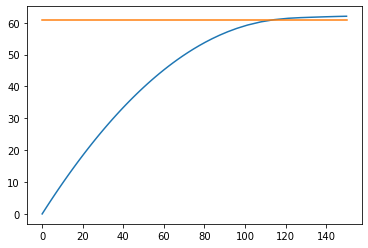

In [16]:
g = lambda t, x: Inflation(x, f=Mpl, omega=omega)

sol2 = solve_ivp(g, [0,150], zini)
plt.plot(sol2.t, sol2.y[0,:])
plt.plot(sol2.t, np.ones(len(sol2.t))*61)

In [20]:
from timer import Timer

omega = H
f = Mpl
t1 = Timer()
t2 = Timer()
t3 = Timer()

func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=True)
print("RK45")
t1.start()
solA = solve_ivp(func, [0, 200] , yini, method="RK45", atol=1e-7, rtol=1e-6)
t1.stop()

func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=True)
print("BDF")
t2.start()
solB = solve_ivp(func, [0, 200] , yini, method="BDF", atol=1e-7, rtol=1e-6)
t2.stop()

func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=True)
print("LSODA")
t3.start()
solC = solve_ivp(func, [0, 200] , yini, method="LSODA", atol=1e-7, rtol=1e-6)
t3.stop()

RK45
Elapsed time: 11.0491 seconds
BDF
Elapsed time: 10.2732 seconds
LSODA
Elapsed time: 33.4598 seconds


In [21]:
file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Data_b25.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)

(201, 6)


In [22]:
stp = max(solA.y[0,:])

/tmp/ipykernel_23647/4291052004.py:2: RuntimeWarning: invalid value encountered in true_divide
  G =  solC.y[-4,:]/solC.y[-10,:]
/tmp/ipykernel_23647/4291052004.py:3: RuntimeWarning: invalid value encountered in true_divide
  B = solC.y[-5,:]/solC.y[-11,:]
/tmp/ipykernel_23647/4291052004.py:4: RuntimeWarning: invalid value encountered in true_divide
  E = solC.y[-6,:]/solC.y[-12,:]


(58.0, 66.89898760730676)

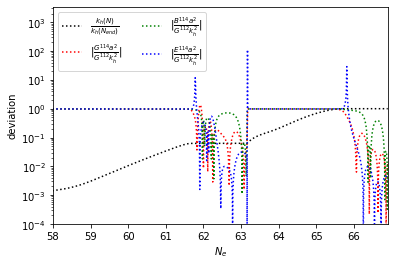

In [30]:
kh = np.exp(solC.y[3,:])
G =  solC.y[-4,:]/solC.y[-10,:]
B = solC.y[-5,:]/solC.y[-11,:]
E = solC.y[-6,:]/solC.y[-12,:]

plt.plot(solC.y[0,:], kh/kh[-1], "k:", label=r"$\frac{k_h(N)}{k_h(N_{end})}$")
plt.plot(solC.y[0,:], abs(G), "r:",
         label=r"$|\frac{G^{114}a^2}{G^{112}k_h^2}|$")
plt.plot(solC.y[0,:], abs(B), "g:",
         label=r"$|\frac{B^{114}a^2}{G^{112}k_h^2}|$")
plt.plot(solC.y[0,:], abs(E), "b:",
         label=r"$|\frac{E^{114}a^2}{G^{112}k_h^2}|$")
plt.legend(loc=0, ncol=2)
plt.yscale("log")
plt.ylabel("deviation")
plt.xlabel(r"$N_e$")
plt.ylim(0.0001)
plt.xlim(60-2, stp)

plotted


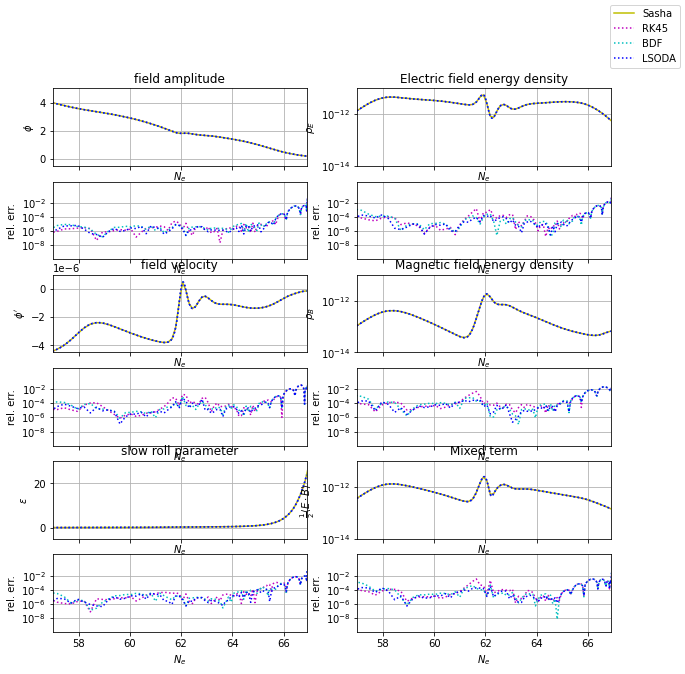

In [25]:
fig, ax = plt.subplots(6,2, figsize=(10,10), sharex=True)

ax[0,0].plot(data[:,0], data[:,1], "y-", label="Sasha")

ax[2,0].plot(data[:,0], data[:,2], "y-", label="Sasha")

ax[4,0].plot(data[:,0], 1/data[:,1]**2, "y-", label="Sasha")

ax[0,1].plot(data[:,0], 0.5*data[:,3], "y-", label="Sasha")

ax[2,1].plot(data[:,0], 0.5*data[:,4], "y-", label="Sasha")

ax[4,1].plot(data[:,0], 0.5*abs(data[:,5]), "y-", label="Sasha")


col = "m:"#, "g:", "c:", "m:"]
    
ax[0,0].plot(solA.y[0,:], solA.y[1,:]*f, col, label="RK45")
ax[2,0].plot(solA.y[0,:], solA.y[2,:]*f*omega, col, label="approx")
ax[4,0].plot(solA.y[0,:], 1/(solA.y[1,:]*f)**2, col, label="approx")
    
ax[0,1].plot(solA.y[0,:], 0.5*solA.y[4,:]*omega**4, col, label="approx")
ax[2,1].plot(solA.y[0,:], 0.5*solA.y[5,:]*omega**4, col, label="approx")
ax[4,1].plot(solA.y[0,:], abs(0.5*solA.y[6,:])*omega**4, col, label="approx")

print("plotted")

col= "c:"
    
ax[0,0].plot(solB.y[0,:], solB.y[1,:]*f, col, label="BDF")
ax[2,0].plot(solB.y[0,:], solB.y[2,:]*f*omega, col, label="exact")
ax[4,0].plot(solB.y[0,:], 1/(solB.y[1,:]*f)**2, col, label="exact")
    
ax[0,1].plot(solB.y[0,:], 0.5*solB.y[4,:]*omega**4, col, label="exact")
ax[2,1].plot(solB.y[0,:], 0.5*solB.y[5,:]*omega**4, col, label="exact")
ax[4,1].plot(solB.y[0,:], abs(0.5*solB.y[6,:]*omega**4), col, label="exact")

col = "b:"

ax[0,0].plot(solC.y[0,:], solC.y[1,:]*f, col, label="LSODA")
ax[2,0].plot(solC.y[0,:], solC.y[2,:]*f*omega, col, label="exact")
ax[4,0].plot(solC.y[0,:], 1/(solC.y[1,:]*f)**2, col, label="exact")
    
ax[0,1].plot(solC.y[0,:], 0.5*solC.y[4,:]*omega**4, col, label="exact")
ax[2,1].plot(solC.y[0,:], 0.5*solC.y[5,:]*omega**4, col, label="exact")
ax[4,1].plot(solC.y[0,:], abs(0.5*solC.y[6,:]*omega**4), col, label="exact")

ax[0,1].set_title("Electric field energy density")
ax[0,1].set_ylabel(r"$\rho_E$")
ax[0,1].set_xlabel(r"$N_e$")
ax[0,1].set_yscale("log")

ax[2,1].set_title("Magnetic field energy density")
ax[2,1].set_ylabel(r"$\rho_B$")
ax[2,1].set_xlabel(r"$N_e$")
ax[2,1].set_yscale("log")

ax[4,1].set_title("Mixed term")
ax[4,1].set_ylabel(r"$\frac{1}{2}\langle E \cdot B \rangle$")
ax[4,1].set_xlabel(r"$N_e$")
ax[4,1].set_yscale("log")

ax[2,0].set_title("field velocity")
ax[2,0].set_ylabel(r"$\phi'$")
ax[2,0].set_xlabel(r"$N_e$")

ax[0,0].set_title("field amplitude")
ax[0,0].set_ylabel(r"$\phi$")
ax[0,0].set_xlabel(r"$N_e$")

ax[4,0].set_title("slow roll parameter")
ax[4,0].set_ylabel(r"$\epsilon$")
ax[4,0].set_xlabel(r"$N_e$")

from scipy.interpolate import CubicSpline

spl = np.interp(data[:,0], solA.y[0,:], solA.y[1,:]*f)
ax[1,0].plot(data[:,0], abs(spl/data[:,1]-1), "m:", label="approx err")
spl = np.interp(data[:,0], solB.y[0,:], solB.y[1,:]*f)
ax[1,0].plot(data[:,0], abs(spl/data[:,1]-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], solC.y[1,:]*f)
ax[1,0].plot(data[:,0], abs(spl/data[:,1]-1), "b:", label="exact err")

ax[1,0].set_ylabel("rel. err.")
ax[1,0].set_xlabel(r"$N_e$")
ax[1,0].set_yscale("log")

spl = np.interp(data[:,0], solA.y[0,:], solA.y[2,:]*f*omega)
ax[3,0].plot(data[:,0], abs(spl/data[:,2]-1), "m:", label="approx err")
spl = np.interp(data[:,0], solB.y[0,:], solB.y[2,:]*f*omega)
ax[3,0].plot(data[:,0], abs(spl/data[:,2]-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], solC.y[2,:]*f*omega)
ax[3,0].plot(data[:,0], abs(spl/data[:,2]-1), "b:", label="exact err")

ax[3,0].set_ylabel("rel. err.")
ax[3,0].set_xlabel(r"$N_e$")
ax[3,0].set_yscale("log")

spl = np.interp(data[:,0], solA.y[0,:], 1/(solA.y[1,:]*f)**2)
ax[5,0].plot(data[:,0], abs(spl*data[:,1]**2-1), "m:", label="approx err")
spl = np.interp(data[:,0], solB.y[0,:], 1/(solB.y[1,:]*f)**2)
ax[5,0].plot(data[:,0], abs(spl*data[:,1]**2-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], 1/(solC.y[1,:]*f)**2)
ax[5,0].plot(data[:,0], abs(spl*data[:,1]**2-1), "b:", label="exact err")

ax[5,0].set_ylabel("rel. err.")
ax[5,0].set_xlabel(r"$N_e$")
ax[5,0].set_yscale("log")

spl = np.interp(data[:,0], solA.y[0,:], solA.y[4,:]*omega**4)
ax[1,1].plot(data[:,0], abs(spl/data[:,3]-1), "m:", label="approx err")
spl = np.interp(data[:,0], solB.y[0,:], solB.y[4,:]*omega**4)
ax[1,1].plot(data[:,0], abs(spl/data[:,3]-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], solC.y[4,:]*omega**4)
ax[1,1].plot(data[:,0], abs(spl/data[:,3]-1), "b:", label="exact err")

ax[1,1].set_ylabel("rel. err.")
ax[1,1].set_xlabel(r"$N_e$")
ax[1,1].set_yscale("log")

spl = np.interp(data[:,0], solA.y[0,:], solA.y[5,:]*omega**4)
ax[3,1].plot(data[:,0], abs(spl/data[:,4]-1), "m:", label="approx err")
spl = np.interp(data[:,0], solB.y[0,:], solB.y[5,:]*omega**4)
ax[3,1].plot(data[:,0], abs(spl/data[:,4]-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], solC.y[5,:]*omega**4)
ax[3,1].plot(data[:,0], abs(spl/data[:,4]-1), "b:", label="exact err")

ax[3,1].set_ylabel("rel. err.")
ax[3,1].set_xlabel(r"$N_e$")
ax[3,1].set_yscale("log")

spl = np.interp(data[:,0], solA.y[0,:], solA.y[6,:]*omega**4)
ax[5,1].plot(data[:,0], abs(spl/data[:,5]-1), "m:", label="approx err")
spl = np.interp(data[:,0], solB.y[0,:], solB.y[6,:]*omega**4)
ax[5,1].plot(data[:,0], abs(spl/data[:,5]-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], solC.y[6,:]*omega**4)
ax[5,1].plot(data[:,0], abs(spl/data[:,5]-1), "b:", label="exact err")

ax[5,1].set_ylabel("rel. err.")
ax[5,1].set_xlabel(r"$N_e$")
ax[5,1].set_yscale("log")

lines_labels = [ax[0,0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

a = np.arange(2, 9, 2)
for i in range(3):
    ax[2*i+1,0].set_ylim(10.**(-10), 10**1)
    ax[2*i+1,0].set_yticks(10.**(-a))
    
    ax[2*i+1,1].set_ylim(10.**(-10), 10**1)
    ax[2*i+1,1].set_yticks(10.**(-a))
    
ax[0,0].set_ylim(-0.5,5)
ax[2,0].set_ylim(-4.5e-6,1e-6)
ax[4,0].set_ylim(-5,30)

ax[0,1].set_ylim(1e-14, 1e-11)
ax[2,1].set_ylim(1e-14, 1e-11)
ax[4,1].set_ylim(1e-14, 1e-11)

for ax in fig.axes:
    ax.grid(True)
    ax.set_xlim(57, stp)
plt.show()

# Anber Sorbo Setup

In [35]:
def EBGnIntegrand(k, xi, a, n):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*xi)

    Whitt1Plus = whitw(-xi*(1j), 1/2, -2j*k/a)
    Whitt2Plus = whitw(1-xi*(1j), 1/2, -2j*k/a)
    
    Whitt1Minus = whitw(xi*(1j), 1/2, -2j*k/a)
    Whitt2Minus = whitw(1+xi*(1j), 1/2, -2j*k/a)
    
    EtermPlus = abs((1j*k/a - 1j*xi) * Whitt1Plus + Whitt2Plus)**2
    EtermMinus = abs((1j*k/a + 1j*xi) * Whitt1Minus + Whitt2Minus)**2
    
    BtermPlus = abs(Whitt1Plus)**2
    BtermMinus = abs(Whitt1Minus)**2
    
    GtermPlus = (Whitt2Plus*Whitt1Plus.conjugate()).real
    GtermMinus = (Whitt2Minus*Whitt1Minus.conjugate()).real
    
    #ErotnE = int(Edk) 
    E = k**(1+n) * a**(-n-2) / (4*np.pi**2) * (expterm[0]*EtermPlus + (-1)**n * expterm[1]*EtermMinus)
    
    #BrotnB = int(Bdk) 
    B = k**(3+n) * a**(-n-4) / (4*np.pi**2) * (expterm[0]*BtermPlus + (-1)**n * expterm[1]*BtermMinus)
    
    #-ErotnB = int(Gdk)
    G =  k**(2+n) * a**(-n-3) / (4*np.pi**2 ) * (expterm[0]*GtermPlus - (-1)**n * expterm[1]*GtermMinus)
    return E, B, G

def ComputeEBGn(xi, a, n):
    
    E = lambda k: EBGnIntegrand(k, xi, a, n)[0]
    B = lambda k: EBGnIntegrand(k, xi, a, n)[1]
    G = lambda k: EBGnIntegrand(k, xi, a, n)[2]
    
    kh = 2*a*abs(xi)
    
    En = quad(E, 0, kh)[0]
    Bn = quad(B, 0, kh)[0]
    Gn = quad(G, 0, kh)[0]
    
    return En*a**n/kh**n, Bn*a**n/kh**n, Gn*a**n/kh**n

def ConstPotentialSlope(xi, G, H, Iterm):
    return -(2*(3-alpha)*H**2*xi/Iterm + Iterm*G)

def SetupConstH(xi, beta, a, ntr, file=None):
    Fvec = np.zeros(3*ntr)
    
    #H=1
    Mpl = 1.0
    H = 2e-7*(beta/100)**(-1/2)*np.exp(-2.85*(xi-7))
    #Mpl = 0.5e7*(beta/100)**(1/2)*np.exp(2.85*(xi-7))*H
    
    ratio = (H/Mpl)
    print(ratio)
    
    if(file==None):
        F = np.zeros((ntr, 3))
        for i in range(ntr):
            #unitless, powers of H need to be restored
            F[i,:] = ComputeEBGn(xi, a, i)
            print(str(int(3*(i+1))) + " out of " + str(int(3*ntr)) + " bilinear terms computed")

        DataDic = dict(E = list(F[:,0]), B = list(F[:,1]), G = list(F[:,2]))
        
        output_df = pd.DataFrame(DataDic)  
        filename = "ConstH_xi" + str(xi) + "_Initialiser.dat"
        output_df.to_csv(filename)
                
    else:
        input_df = pd.read_table(file, sep=",")
        data = input_df.values
        if (np.shape(data)[0]<ntr):
            nprog = np.shape(data)[0]
            print("need to compute "+str(int(3*(ntr-nprog))) + " more bilinear terms")
            F = np.zeros((ntr, 3))
            F[:nprog,0] = data[:,1].T
            F[:nprog,1] = data[:,2].T
            F[:nprog,2] = data[:,3].T
            
            for i in range(nprog, ntr):
                F[i,:] = ComputeEBGn(xi, a, i)
                print(str(int(3*(i+1-nprog))) + " out of " + str(int(3*(ntr-nprog))) + " bilinear terms computed")

            DataDic = dict(E = list(F[:,0]), B = list(F[:,1]), G = list(F[:,2]))
        
            output_df = pd.DataFrame(DataDic)  
            output_df.to_csv(file)
        else:
            F = np.array([data[:ntr,1], data[:ntr,2], data[:ntr,3]]).T
        
    Fvec = F.reshape(3*ntr)
    
    lnkh = np.log(2*a*abs(xi))
    
    """g = ConstPotentialSlope(xi, F[0,2]*H**4, H, beta/Mpl)
    h = (H**2*Mpl**2) * (3 - 2*xi**2/beta**2) - 0.5 * (F[0,0]+ F[0,1]) * H**4
    
    phi0 = 2*h/g
    print(phi0)
    m2 = g**2/(2*h)
    #units restored, needed for GEF wrapper
    print(F[0,2])"""
    Vprime = ConstPotentialSlope(xi, F[0,2]*H**4, H, beta/Mpl)
    V0 = (H*Mpl)**2 * (3 - 2*xi**2/beta**2) - 0.5 * (F[0,0]+ F[0,1]) * H**4
    
    dIdphi = beta/Mpl
    print(F[0,:]*H**4)
    
    f = Mpl
    omega = H
    
    #return Fvec, lnkh, m2, phi0, dIdphi, f, omega
    return Fvec, lnkh, V0, Vprime, dIdphi, f, omega
    

In [36]:
alpha = 0
ntr = 140
xi = 7
beta = 10**(2.0)
phi0 = 0
#F, lnkh, m2, phi0, dIdphi, f, omega = SetupConstH(xi, beta, 1., ntr, file="ConstH_xi_7_Initialiser.dat")
F, lnkh, V0, Vprime, dIdphi, f, omega = SetupConstH(xi, beta, 1., ntr, file="ConstH_xi_7_Initialiser.dat")
#dimless velocity
Mpl = f
dphidt0 = 2*xi/beta

def potential(phi):
    return Vprime*phi + V0
    #return 0.5*m2*phi**2

def dIdphi(phi):
    return beta/Mpl

def ddIddphi(phi):
    return 0

def dVdphi(phi):
    return Vprime
    #return m2*phi

print(f)
print(omega)
print(Vprime, V0)
print(f/2*abs(Vprime)**2/V0**2)
zini = np.zeros(ntr*3+4)
zini[0] = 0.
zini[1] = phi0/f
zini[2] = dphidt0
zini[3] = lnkh
zini[4:] = F

2e-07
[1.54402918e-14 3.70561606e-16 2.25869334e-15]
1.0
2e-07
-2.4266933406170634e-13 1.1170257330661036e-13
2.3597904800630194


In [ ]:
func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=True)

sol = solve_ivp(func, [0,100] , zini, method="RK45")

/tmp/ipykernel_23647/2829141850.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  if ((kh-f)/kh <= 1e-3):
/tmp/ipykernel_23647/2829141850.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  dlnkhdt = fprime/kh
/tmp/ipykernel_23647/1206169590.py:9: RuntimeWarning: invalid value encountered in double_scalars
  prefac = dlnkhdt * delta/ (4*np.pi**2) * (kh/a)**4
/tmp/ipykernel_23647/3355844793.py:16: RuntimeWarning: invalid value encountered in double_scalars
  dFdt[n,0] = (bdrF[n, 0] - (4*H + 2*a**(alpha) * sigma + n*dlnkhdt)*F[n,0]
/tmp/ipykernel_23647/3355844793.py:19: RuntimeWarning: invalid value encountered in double_scalars
  dFdt[n,1] = bdrF[n, 1] - (4*H + n*dlnkhdt)*F[n,1] + 2*a**(alpha) * (kh/a) * F[n+1,2]
/tmp/ipykernel_23647/3355844793.py:21: RuntimeWarning: invalid value encountered in double_scalars
  dFdt[n,2] = (bdrF[n, 2] - (4*H + a**(alpha) * sigma + n*dlnkhdt)*F[n,2]
/home/richard/anaconda3/lib/python3.9/site-packages/scipy/integrate

In [ ]:
plt.plot(sol.y[0,:], sol.y[3,:])
plt.plot(sol.y[0,:], sol.y[0,:]+np.log(abs(sol.y[2,:])) + np.log(beta))
plt.show()
plt.plot(sol.y[0,:], sol.y[1,:])
plt.show()

In [ ]:
V = potential(sol.y[1,:]*f)/(omega**2*f**2)

Hsq = FriedmannEq(np.exp(sol.y[0,:]), sol.y[2,:], V, sol.y[4,:], sol.y[5,:], f, omega/f)
plt.plot(sol.y[0,:], np.sqrt(Hsq))
plt.show()
plt.plot(sol.y[0,:], np.log(abs(sol.y[-4,:]/sol.y[-10,:])))
plt.plot(sol.y[0,:], np.log(abs(sol.y[-5,:]/sol.y[-11,:])))
plt.plot(sol.y[0,:], np.log(abs(sol.y[-6,:]/sol.y[-12,:])))
plt.plot(sol.y[0,:], 1., "r:")
plt.show()
plt.plot(sol.y[0,:], np.log10(abs(beta*sol.y[2,:]/(2*np.sqrt(Hsq))-7.)/7.))
plt.plot(sol.y[0,:], np.ones(len(sol.y[0,:]))*(-0.5))
plt.show()

In [160]:
HConst = 1
xi = 7
beta = 100
Mpl = 0.5e7*(beta/100)**(1/2)*np.exp(2.85*(xi-7))*HConst
yini, dVini = SetupConstH(xi, HConst, 1, 190, file="ConstH_xi_7_Initialiser.dat")
dVini = dVini/Mpl

(190, 3)
(190, 3)


In [161]:
print(yini[3])
steps = int(1e6)
N = np.linspace(0, 50, steps)
t = N/HConst
print(t[0])
print(t[-1])
t = t - t[0]
#print(yini)

func = lambda t, x: ConstHGEF(x, t, HConst, dVini, beta, omega=HConst, f=Mpl, approx=False)
#print(dVini)
#print(yini[2:5])
#print(yini[5:8])
#dydtini = func(0, yini)
#print("out: ", dydtini[2:5])

2.3160100403072797e+11
0.0
50.0


In [162]:
print(np.shape(yini.T))

sol = solve_ivp(func, [t[0], t[-1]] , yini)

(572,)


(572, 3050)


/tmp/ipykernel_15899/3182612323.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(sol.t, np.log10(abs((sol.y[0,:]-7)/7)))


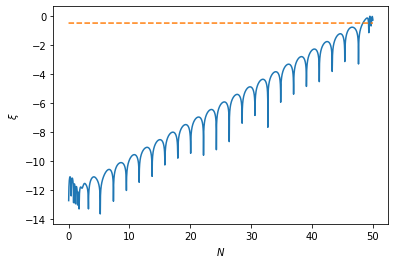

In [163]:
print(np.shape(sol.y))
#print(sol.y[2,:])
plt.plot(sol.t, np.log10(abs((sol.y[0,:]-7)/7)))
plt.plot(sol.t, np.ones(len(sol.t))*(-0.5), "--")
#plt.plot(sol.t, 7.0*np.ones(len(sol.t)), "--")
#plt.plot(sol.t, 9.21*np.ones(len(sol.t)), "y--")
#plt.plot(sol.t, 4.79*np.ones(len(sol.t)), "y--")
plt.xlabel(r"$N$")
plt.ylabel(r"$\xi$")
plt.show()

(572, 3398)


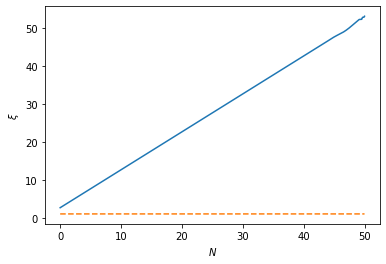

In [40]:
print(np.shape(sol.y))
#print(sol.y[2,:])
plt.plot(sol.t, (sol.y[1,:]))
plt.plot(sol.t, np.ones(len(sol.t)), "--")
#plt.plot(sol.t, 7.0*np.ones(len(sol.t)), "--")
#plt.plot(sol.t, 9.21*np.ones(len(sol.t)), "y--")
#plt.plot(sol.t, 4.79*np.ones(len(sol.t)), "y--")
plt.xlabel(r"$N$")
plt.ylabel(r"$\xi$")
plt.show()

In [93]:
def getNCut(t, xi, xi0, prec=10**(-0.5)):
    for i in range(len(xi)):
        diff = abs(xi[i]-xi0)/xi0
        if (diff > prec):
            return t[i]
    return False

def NCutbyDelta(t, yini, vals, prec=10**(-0.5)):
    xi0 = yini[0]
    print(xi0)
    print(np.arange(1, vals))
    delta = 1/10**(np.arange(1, vals+1))
    xis = (delta+1)*xi0
    print(xis)
    NCut = []
    #delta = []
    for i in range(vals):
        yini[0] = xis[i]
        #sol = solve_ivp(func, [t[0], t[-1]] , yini)
        #NCut.append(getNCut(sol.t, sol.y[0,:], xi0, prec=10**(-0.5)))
    yini[0] = xi0
    delta = list(delta)
    return delta, NCut

def PlotNCutvsDelta(xi0, style="r."):
    file = "NCut_xi_" + str(xi0) + ".dat"
    input_df = pd.read_table(file, sep=",")
    data = input_df.values
    delta = data[:,1]
    NCut = data[:,2]
    plt.plot(delta, NCut, style, label=r"$\Delta N_e$ for $\xi_0=$" + str(xi0))
    plt.xlabel(r"$|\xi-\xi_0|$")
    plt.ylabel(r"$\Delta N_e$")
    plt.legend(loc=0)
    plt.show()
    return

def PlotNCutvsDeltaLog(xi0, I, style="r."):
    filebeg = "NCut_xi_" + str(xi0) + "_del"
    filend = "_I" + str(I) + "_log.dat"
    input_df = pd.read_table(file, sep=",")
    data = input_df.values
    delta = data[:,1]
    NCut = data[:,2]
    plt.plot(np.log10(delta), NCut, style, label=r"$\Delta N_e$ for $\xi_0=$" + str(xi0))
    plt.xlabel(r"$\log_{10}(|\xi-\xi_0|)$")
    plt.ylabel(r"$\Delta N_e$")
    plt.legend(loc=0)
    plt.show()
    return

def ReadFile(xi0, I, delta=None):
    filebeg = "Out_" + str(xi0) "_"
    filend = "_I" + str(I) + "_log.dat"
    if (delta == None):
        filename = filebeg + "base" + filend
    else:
        filename = filebeg + "del" + str(delta) + filend

    pwd = os.getcwd()
    path = os.path.join(pwd, filename)
    file = os.path.exists(path)
    if (not file):
        "There is no such file"
        return
    else:
        input_df = pd.read_table(file, sep=",")
        data = input_df.values
        t = data[:,1]
        y = data[:,2:]
    return t, y

In [63]:
print(NCutbyDelta(t, yini, 10))

7.000000007000001
[1 2 3 4 5 6 7 8 9]
[7.70000001 7.07000001 7.00700001 7.00070001 7.00007001 7.00000701
 7.00000071 7.00000008 7.00000001 7.00000001]
([0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10], [])


In [99]:
#Plus Sol
print(getNCut(sol.t, sol.y[0,:], 7.0))

1.0778432079856222e+01


In [94]:
print(getNCut(sol.t, sol.y[0,:], 7.0))

8.812767894971508e+00


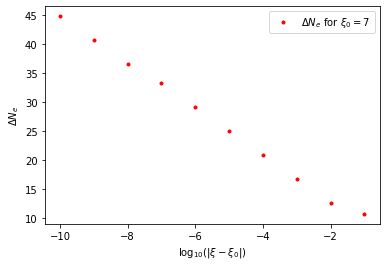

In [65]:
PlotNCutvsDeltaLog(7)

(596, 3671)


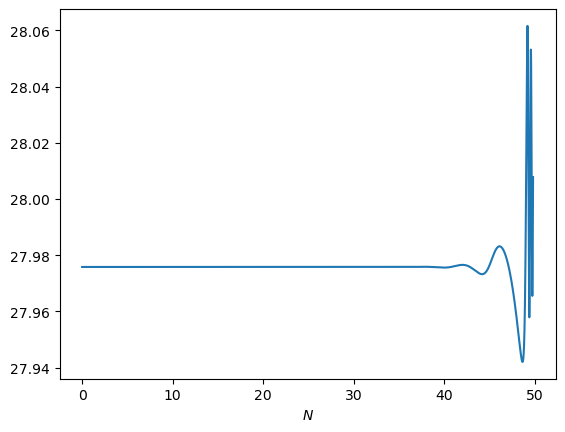

In [31]:
print(np.shape(sol.y))
#print(sol.y[2,:])
plt.plot(sol.t, np.log(abs(sol.y[4,:])))
plt.xlabel(r"$N$")
plt.show()

In [98]:
def ComputeEEBB(x, a, H):
    kh = 2*a*H*x
    
    f = lambda k: GetIntEEBB(k, x, a, H)
    
    EEBB = quad(f, 0, kh)[0]
    return EEBB

def ComputeEB(x, a, H):
    kh = 2*a*H*x
    
    f = lambda k: GetIntEEBB(k, x, a, H)
    
    EB = quad(f, 0, kh)[0]
    return EB

def GetIntEB(k, x, a, H):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*x)
    
    Whitt1Plus = whitw(-x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Plus = whitw(1-x*(1j), 1/2, -2j*k/(a*H))
    
    Whitt1Minus = whitw(x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Minus = whitw(1+x*(1j), 1/2, -2j*k/(a*H))
    
    GtermPlus = (Whitt2Plus*Whitt1Plus.conjugate()).real
    GtermMinus = (Whitt2Minus*Whitt1Minus.conjugate()).real
    
    return k**2 * a**-3 * H/(4*np.pi**2 ) * (expterm[0]*GtermPlus
                                             - expterm[1]*GtermMinus)

def GetIntEEBB(k, x, a, H):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*x)
    
    Whitt1Plus = whitw(-x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Plus = whitw(1-x*(1j), 1/2, -2j*k/(a*H))
    
    Whitt1Minus = whitw(x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Minus = whitw(1+x*(1j), 1/2, -2j*k/(a*H))
    
    EtermPlus = abs((1j*k/(a*H) - 1j*x) * Whitt1Plus + Whitt2Plus)**2
    EtermMinus = abs((1j*k/(a*H) - 1j*x) * Whitt1Minus + Whitt2Minus)**2
    
    BtermPlus = abs(Whitt1Plus)**2
    BtermMinus = abs(Whitt1Minus)**2
    
    E = k * a**-2 * H/(4*np.pi**2) * (expterm[0]*EtermPlus
                                             + expterm[1]*EtermMinus)
    B = k**3 * a**-4 * H/(4*np.pi**2) * (expterm[0]*EtermPlus
                                             + expterm[1]*EtermMinus)
    
    return (E + B)/2

In [99]:
ComputeEB(1, 1, 1)/(np.exp(2*np.pi))
ComputeEEBB(1, 1, 1)/(np.exp(2*np.pi))

0.002005904173288318

In [85]:
H = 1
a = 1


EBcut = lambda x: ComputeEB(x, a, H)/(np.exp(2*np.pi*x)/x**4)

x = np.linspace(1, 100, 100)

EBapprox = np.ones(x.size)*(2.6e-4*H**4)

Eres = np.array([EBcut(x[i]) for i in range(x.size)]) 



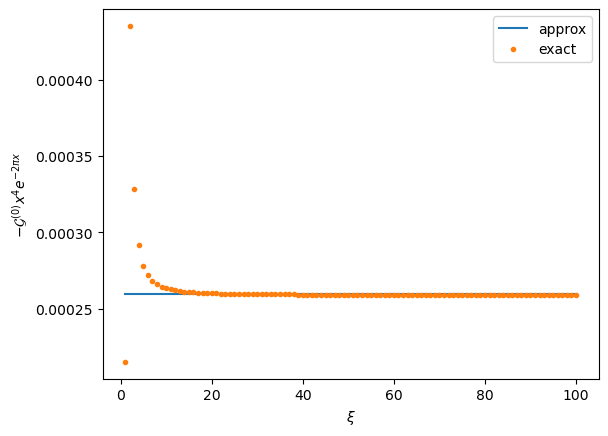

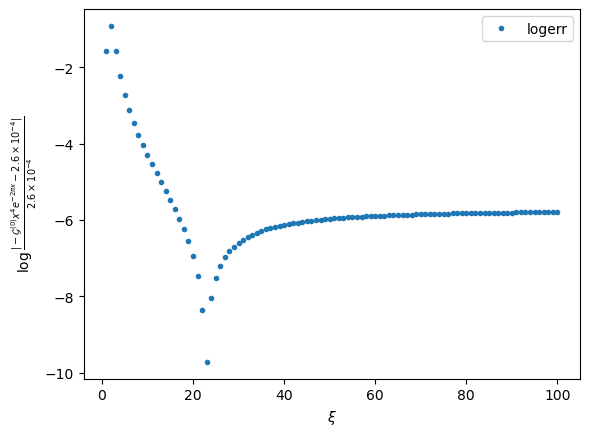

In [113]:
#plt.plot(x, EBapprox, ".", label="Approx")
#plt.plot(x, Eres, ".", label="exact")
plt.plot(x, EBapprox, label="approx")
plt.plot(x, Eres, ".", label="exact")
plt.legend(loc=0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$-\mathcal{G}^{(0)} x^4 e^{-2 \pi x}$")
plt.show()
plt.plot(x, np.log(abs(EBapprox-Eres)/abs(Eres)), ".", label="logerr")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\log \frac{|-\mathcal{G}^{(0)} x^4 e^{-2 \pi x} - 2.6 \times 10^{-4}|}{2.6 \times 10^{-4}}$")
plt.legend(loc=0)
plt.show()

In [100]:
EEBBcut = lambda x: ComputeEEBB(x, a, H)/(np.exp(2*np.pi*x)/x**3)

x = np.linspace(1, 100, 100)

EEBBapprox = np.ones(x.size)*(1.4e-4*H**4)

EEBBres = np.array([EEBBcut(x[i]) for i in range(x.size)]) 


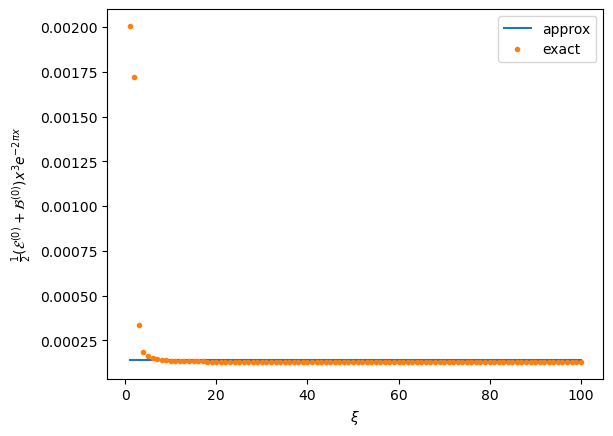

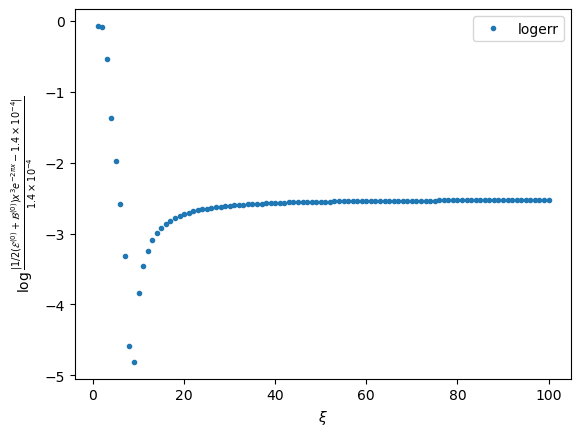

In [117]:
#plt.plot(x, EBapprox, ".", label="Approx")
#plt.plot(x, Eres, ".", label="exact")
plt.plot(x, EEBBapprox, label="approx")
plt.plot(x, EEBBres, ".", label="exact")
plt.legend(loc=0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\frac{1}{2}(\mathcal{E}^{(0)} + \mathcal{B}^{(0)}) x^3 e^{-2 \pi x}$")
plt.show()
plt.plot(x, np.log(abs(EEBBapprox-EEBBres)/abs(EEBBres)), ".", label="logerr")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\log \frac{|1/2 (\mathcal{E}^{(0)} + \mathcal{B}^{(0)}) x^3 e^{-2 \pi x}- 1.4 \times 10^{-4}|}{1.4 \times 10^{-4}}$")
plt.legend(loc=0)
plt.show()

In [23]:
comp = yini[2:].reshape(192,3)
comp[:, [1,2]] = comp[:,[2,1]]
data = np.genfromtxt('InitCond_xi7.dat', dtype=float)

def CompareData(N, comp, data):
    x1 = comp
    x2 = data[N, 1:]
    #print(x1)
    #print(x2)
    err = abs((x1-x2)/x2)
    sgn = x1/x2
    return err, sgn

err = np.zeros((comp.shape))
sgn = np.zeros((comp.shape))
for i in range(192):
    err[i,:], sgn[i,:] = CompareData(i, comp[i,:], data)
    
print(err)
print(sgn)

[[1.22551825e-09 1.12831344e-09 9.37223439e-10]
 [1.14314803e-09 8.85938454e-10 4.32646654e-10]
 [8.31348357e-10 2.45508387e-10 7.26026071e-10]
 [1.92389456e-09 1.15275269e-09 3.02113475e-09]
 [1.56837710e-09 3.67614934e-09 7.44625259e-09]
 [2.37948354e-07 7.98032743e-09 1.52766278e-08]
 [9.01332610e-09 1.50761111e-08 3.07870858e-08]
 [2.59758542e-09 2.56157048e-08 4.71519559e-08]
 [3.23659202e-08 3.83040889e-08 6.51343682e-08]
 [9.17906374e-08 4.68078977e-08 5.61004380e-08]
 [6.57617556e-08 4.59984692e-08 4.34541278e-08]
 [1.04700455e-05 3.63798343e-08 2.71934914e-08]
 [2.65801238e-08 2.55038509e-08 1.77859364e-08]
 [6.15745869e-06 1.63392493e-08 9.84999963e-09]
 [9.18144872e-09 1.02913945e-08 5.90604248e-09]
 [3.90383754e-07 6.24336435e-09 3.62115153e-09]
 [2.94963417e-09 3.89469185e-09 1.91634939e-09]
 [2.45608481e-07 2.19975237e-09 1.12351284e-09]
 [1.12587660e-09 1.24206541e-09 5.74817268e-10]
 [3.82454796e-07 6.94780267e-10 3.22745290e-10]
 [5.59758048e-10 3.69146194e-10 1.485344

In [169]:
comp = dydtini[2:].reshape(198,3)
comp[:, [1,2]] = comp[:,[2,1]]
data = np.genfromtxt('Tab_deriv_198.dat', dtype=float)

def CompareData(N, comp, data):
    x1 = comp
    x2 = data[N, 1:]
    #print(x1)
    #print(x2)
    err = abs((x1-x2)/x2)
    sgn = x1/x2
    return err, sgn

err = np.zeros((comp.shape))
sgn = np.zeros((comp.shape))
for i in range(198):
    err[i,:], sgn[i,:] = CompareData(i, comp[i,:], data)
    
print(err)
print(sgn)

[[0.00000000e+00 9.20167932e-01 1.15249905e+01]
 [4.00608926e-05 4.69877919e+00 8.24379094e-01]
 [3.82738494e-04 9.60604803e-01 2.17856176e+01]
 [1.71648164e-01 1.47280967e+00 1.28894590e+00]
 [8.75671527e-01 1.03345199e+00 1.24650732e+00]
 [2.44736842e+00 9.84547490e-01 9.99871523e-01]
 [9.95420815e-01 1.00095079e+00 1.00035789e+00]
 [9.99594844e-01 9.99991709e-01 1.00000428e+00]
 [9.99997263e-01 1.00000000e+00 1.00000012e+00]
 [9.99998525e-01 9.99998734e-01 9.99999185e-01]
 [9.99999940e-01 1.00000029e+00 1.00000014e+00]
 [9.99999890e-01 1.00000001e+00 1.00000015e+00]
 [9.99999990e-01 1.00000107e+00 9.99999865e-01]
 [1.00000004e+00 9.99999814e-01 1.00000007e+00]
 [1.00000732e+00 9.99975840e-01 9.99999651e-01]
 [1.00001192e+00 9.99995895e-01 1.00000340e+00]
 [9.99998990e-01 9.99998629e-01 1.00000031e+00]
 [1.00000058e+00 9.99999889e-01 9.99999921e-01]
 [9.99999954e-01 9.99999956e-01 1.00000001e+00]
 [9.99999965e-01 9.99999969e-01 1.00000001e+00]
 [9.99999986e-01 9.99999959e-01 9.999999

In [31]:
n = np.random.randint(200, 300)
n=26
print(n)
dataN = np.array(ComputeEBGn(7., 1., 1., n))
print(dataN)
print(data[n,1:])
dataN[[1,2]] = dataN[[2,1]]
print(CompareData(n, dataN, data))

26
[3.66679423e+31 1.06650851e+32 1.59509134e+31]
[5.63585790e+23 2.54284819e+25 2.38979299e+23]
(array([6.50618636e+07, 6.27284321e+05, 4.46276522e+08]), array([6.50618646e+07, 6.27285321e+05, 4.46276523e+08]))


In [46]:
Names = ["n", "E", "B", "G"]
Data = yini[2:].reshape(100, 3)

DataDic = dict(E = list(Data[:,0]), B = list(Data[:,1]), G = list(Data[:,2]))
import pandas as pd
output_df = pd.DataFrame(DataDic)  
output_df.to_csv('output_file_name.dat')

input_df = pd.read_table('output_file_name.dat', sep=",") 
print(input_df.values[:,1])

[ 9.65018236e+012  2.49912527e+012  1.04739809e+012  6.52372520e+011
  5.70831966e+011  6.75023998e+011  1.05236970e+012  2.10847385e+012
  5.69972190e+012  1.65052837e+013  1.13111323e+014  1.25428976e+014
  8.83932193e+015 -2.89653393e+016  1.24547152e+018 -7.02762401e+018
  2.04548927e+020 -1.36812834e+021  3.52956063e+022 -2.55064903e+023
  6.23117710e+024 -4.70164605e+025  1.11519034e+027 -8.64701907e+027
  2.01488900e+029 -1.59173356e+030  3.66679423e+031 -2.93611407e+032
  6.71174459e+033 -5.42939507e+034  1.23444736e+036 -1.00656509e+037
  2.27974983e+038 -1.87075957e+039  4.22514428e+040 -3.48519325e+041
  7.85502664e+042 -6.50737121e+043  1.46437779e+045 -1.21755669e+046
  2.73672990e+047 -2.28252020e+048  5.12599555e+049 -4.28669374e+050
  9.62059546e+051 -8.06413070e+052  1.80894639e+054 -1.51939003e+055
  3.40707955e+056 -2.86689151e+057  6.42706853e+058 -5.41678020e+059
  1.21413208e+061 -1.02475621e+062  2.29665335e+063 -1.94094888e+064
  4.34971349e+065 -3.68035487e+066

In [5]:
HoverMpl = lambda beta, xi: 2e-7*(beta/100)**(-1/2)*np.exp(-2.85*(xi-7))

In [8]:
beta = 10**np.array([1.5, 3.5])
xi = np.array([5,9])

In [16]:
HoverMpl(beta, xi)
from scipy.optimize import fsolve
f = lambda x: HoverMpl(x, 7) - 



SyntaxError: invalid syntax (2749062437.py, line 1)

In [1]:
import numpy as np
print(np.arange(1, 16)[1:])

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [17]:
2.2e-18*6.58e-16

1.4476e-33

In [23]:
beta = 2.45e-5*1.63e-7

In [21]:
HoverMpl(2.45e-5*1.63e-7, 7)

1.0008134915772269e+00

In [3]:
2.45/4

0.6125

In [8]:
HoverMpl(2.45e-5*6.125e6, 7)

1.63265306122449e-07

In [9]:
1/6.125e6

1.63265306122449e-07

76.0


In [37]:

"""yini = np.zeros(100*3+4)
print(yini.shape)
Mpl = 1
M = 6e-6*Mpl
yini[1] = 15.55
yini[2] = - np.sqrt(2/3)*M
Vini = potential(yini[1]*Mpl)
print(Vini)
print(omega)
yini[0] = 0
Iini = Mpl*dIdphi(Mpl*yini[1])
xi = GetXi(yini[2], Iini, 1.0)
print(xi)
yini[3] = np.log(1.0*(1-alpha)*2*abs(xi)*1.0)"""

"""Use beta =10 No back reaction at all (since small coupling), then you should get chaotic inflation,
can be derived analytically, compare. Maybe beta = 0, to check pure chaotic inflation?"""

(304,)
4.352445000000001e-09
3.814203717684728e-05
-2.449489742783178e-05


'Use beta =10 No back reaction at all (since small coupling), then you should get chaotic inflation,\ncan be derived analytically, compare. Maybe beta = 0, to check pure chaotic inflation?'

In [19]:
"""
beta = 31.6
yini = np.zeros(150*3+4)
print(yini.shape)
Mpl = 1
yini[1] = 15.55 * Mpl
yini[2] = 3.5*M*Mpl
Vini = potential(yini[1])
print(Vini)
Hini = np.sqrt( (1/(3*Mpl)) * (0.5 * yini[2]**2 + Vini ) )
print(Hini**2)
yini[0] = 0
Iini = dIdphi(yini[1])
xi = GetXi(yini[2], Iini, Hini)
print(xi)
yini[3] = np.log(1.0*(1-alpha)*2*abs(xi)*Hini)
"""

'\nbeta = 31.6\nyini = np.zeros(150*3+4)\nprint(yini.shape)\nMpl = 1\nyini[1] = 15.55 * Mpl\nyini[2] = 3.5*M*Mpl\nVini = potential(yini[1])\nprint(Vini)\nHini = np.sqrt( (1/(3*Mpl)) * (0.5 * yini[2]**2 + Vini ) )\nprint(Hini**2)\nyini[0] = 0\nIini = dIdphi(yini[1])\nxi = GetXi(yini[2], Iini, Hini)\nprint(xi)\nyini[3] = np.log(1.0*(1-alpha)*2*abs(xi)*Hini)\n'